## Imports & All of Texas Data

In [2]:
import os
import time
import random
import collections
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import networkx as nx
from shapely.geometry import box, Point, LineString
import pickle


#set seed for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Load OpenStreetMap roads shapefile.
roads = gpd.read_file("gis_osm_roads_free_1.shp")

#Grab desired road types
major_classes = [
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "motorway_link", "trunk_link", "primary_link",
    "secondary_link", "tertiary_link",
    "residential", "unclassified", "living_street"
]
roads_major = roads[roads["fclass"].isin(major_classes)]

#Load a pre-built NetworkX graph object from a pickle file.
#statewide time-weighted directed graph
with open("texas_roads.pkl", "rb") as f:
    G = pickle.load(f)

print("Statewide graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


Statewide graph: 5828743 nodes, 7024931 edges


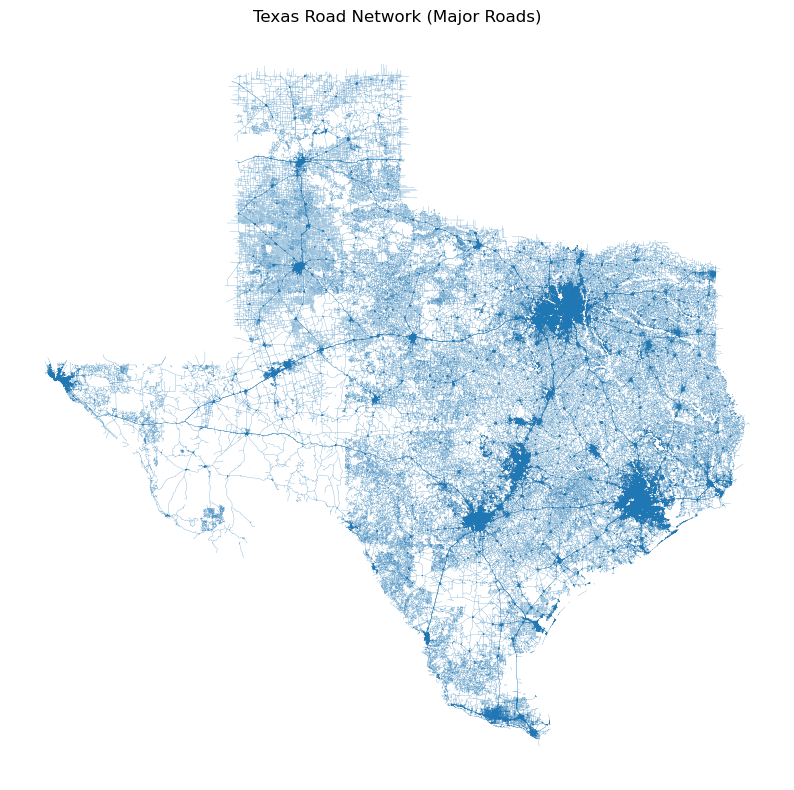

In [3]:
#Road Network of Entire Texas Map:
roads_tx_proj = roads_major.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
roads_tx_proj.plot(ax=ax, linewidth=0.15)
ax.set_title("Texas Road Network (Major Roads)")
ax.set_axis_off()
plt.show()

## Leander & Cedar Park - General Analysis

#### Maps

14505 road segments in Leander + Cedar Park


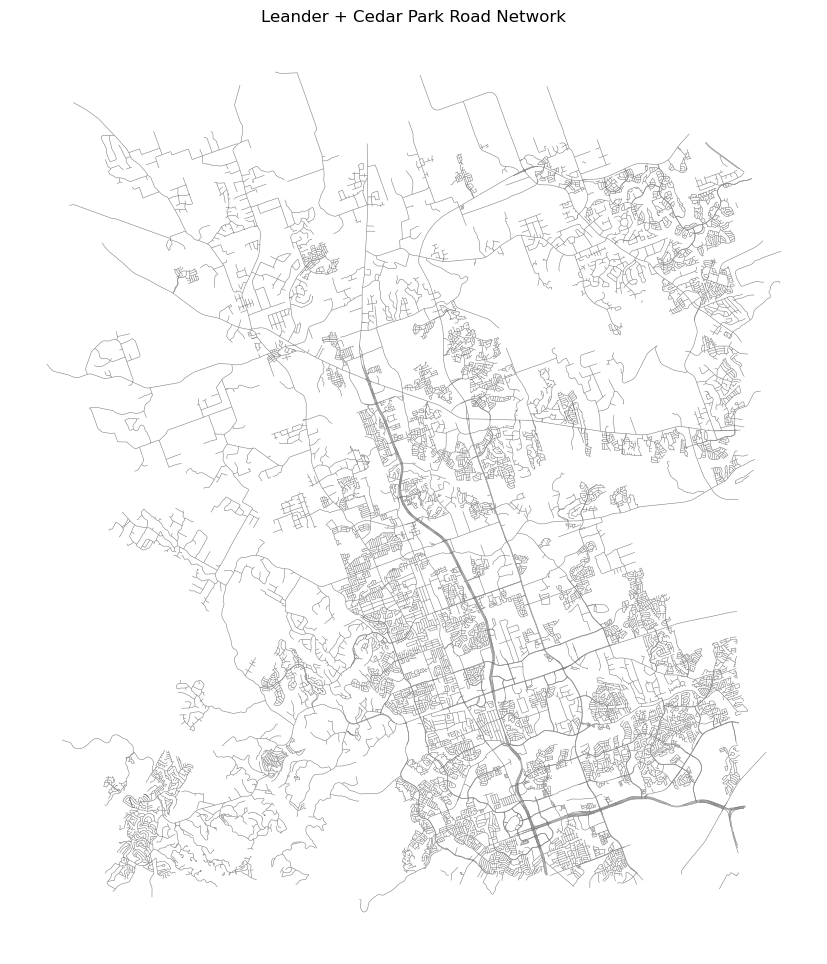

Leander + Cedar Park bbox in EPSG:3857: -10912670.410153793 -10873493.507987987 3559471.498539673 3604291.6463674316
Largest CC (CP+Lea): 8941 nodes, 14802 edges
Merged CP+Lea graph: 8499 nodes, 14105 edges


In [6]:
# Leander + Cedar Park bounding box
cedar_lea_bbox = (-98.00, -97.70, 30.45, 30.75)  # (minx, maxx, miny, maxy) in lon/lat

# Filter roads for Leander and Cedar Park in Texas network by bounding box
cp_lea_roads = roads_major.cx[
    cedar_lea_bbox[0]:cedar_lea_bbox[1],
    cedar_lea_bbox[2]:cedar_lea_bbox[3]
]

print(len(cp_lea_roads), "road segments in Leander + Cedar Park")


cp_lea_proj = cp_lea_roads.to_crs(epsg=3857)

# Quick map
fig, ax = plt.subplots(figsize=(12, 12))
cp_lea_proj.plot(ax=ax, linewidth=0.4, color="gray")
ax.set_title("Leander + Cedar Park Road Network")
ax.set_axis_off()
plt.show()

x_min, y_min, x_max, y_max = cp_lea_proj.total_bounds
print("Leander + Cedar Park bbox in EPSG:3857:", x_min, x_max, y_min, y_max)

#get the subgraph
cp_lea_nodes = [
    n for n in G.nodes
    if x_min <= n[0] <= x_max and y_min <= n[1] <= y_max
]

G_cp_lea = G.subgraph(cp_lea_nodes).copy()

#keep largest weakly connected component
components = list(nx.weakly_connected_components(G_cp_lea))
largest = max(components, key=len)
G_cp_lea_cc = G_cp_lea.subgraph(largest).copy()

print("Largest CC (CP+Lea):", G_cp_lea_cc.number_of_nodes(), "nodes,", G_cp_lea_cc.number_of_edges(), "edges")

# Merge nearby nodes (15 m)(need to get rid of false nodes in road segments)
snap = 15.0  # meters
nodes_df = pd.DataFrame(list(G_cp_lea_cc.nodes()), columns=["x", "y"])
nodes_df["x_snap"] = (nodes_df["x"] / snap).round() * snap
nodes_df["y_snap"] = (nodes_df["y"] / snap).round() * snap

# build a maping from original node coordinates to snapped coordinates.
mapping = {
    (row.x, row.y): (row.x_snap, row.y_snap)
    for row in nodes_df.itertuples(index=False)
}

G_cp_lea_merged = nx.DiGraph()

for u, v, data in G_cp_lea_cc.edges(data=True):
    u2 = mapping[u]
    v2 = mapping[v]
    if u2 == v2:
        continue
        
    #If an edge between the snapped nodes already exists, keep the version with the smaller travel time
    if G_cp_lea_merged.has_edge(u2, v2):
        existing_tt = G_cp_lea_merged[u2][v2].get("travel_time_s", float("inf"))
        new_tt = data.get("travel_time_s", existing_tt)
        if new_tt < existing_tt:
            G_cp_lea_merged[u2][v2].update(data)
    else:
        G_cp_lea_merged.add_edge(u2, v2, **data)

print("Merged CP+Lea graph:", G_cp_lea_merged.number_of_nodes(), "nodes,",
      G_cp_lea_merged.number_of_edges(), "edges")

roads_3857 = cp_lea_roads.to_crs(epsg=3857)


- Line 1: The bounding box coordinates for Leander and Cedar Park
- Line 2 (123453 Nodes): total number of nodes returned inside your bounding box. Includes irrelevant nodes from waterways, footpaths, dead ends, driveway points, parking lots, etc. 
- Line 3 (8941 Nodes): Filtered out irrelevant networks. The largest connected road network contained 8941 Nodes and 14802 edges. 
- Line 4 (8499 Nodes): Employ edge merging where long roads with many mid-block shape nodes get turned into single edges and parallel overlapping geometries get merged.

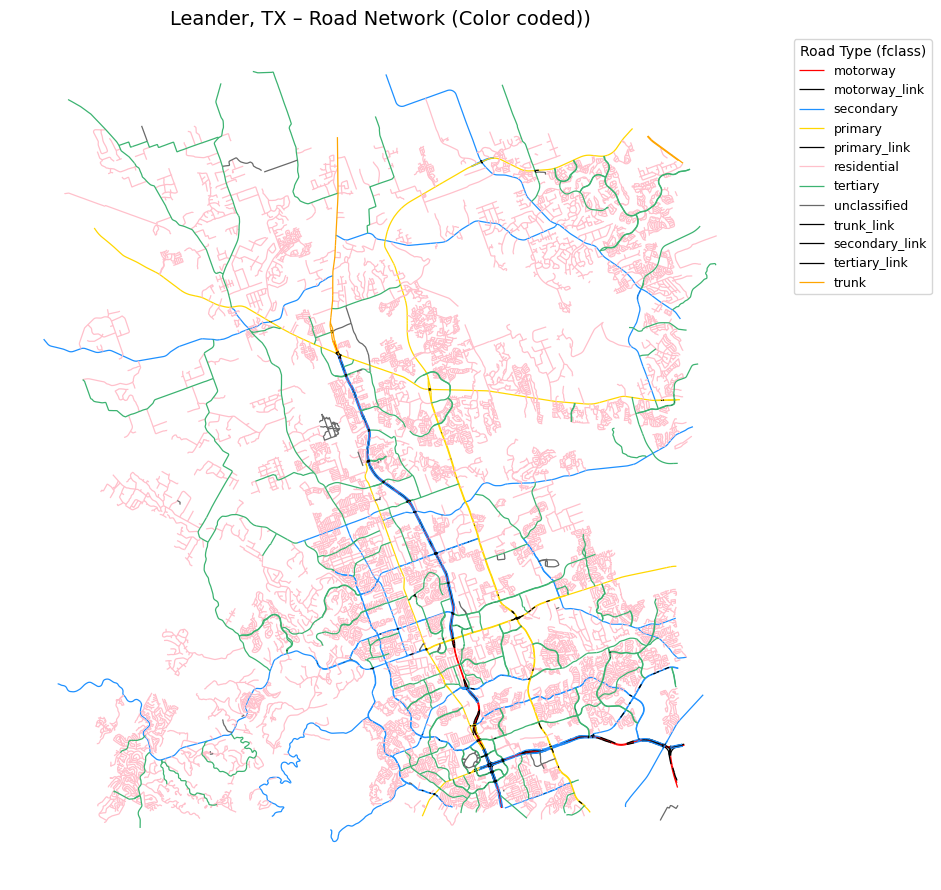

In [8]:
#Leander + Cedar Park bounding box
cedar_lea_bbox = (-98.00, -97.70, 30.45, 30.75)

# Filter roads by bounding box
cp_lea_roads = roads_major.cx[
    cedar_lea_bbox[0]:cedar_lea_bbox[1],
    cedar_lea_bbox[2]:cedar_lea_bbox[3]
]
cp_lea_proj = cp_lea_roads.to_crs(epsg=3857)

# Custom color palette
color_map = {
    "motorway": "red",
    "trunk": "orange",
    "primary": "gold",
    "secondary": "dodgerblue",
    "tertiary": "mediumseagreen",
    
    # Minor roads
    "residential": "pink",
    "unclassified": "dimgray",
    "living_street": "lightgray",
    "service": "lightgray",
    
    # Tracks
    "track": "saddlebrown",
    "track_grade1": "saddlebrown",
    "track_grade2": "sienna",
    "track_grade3": "peru",
    "track_grade4": "tan",
    "track_grade5": "wheat",

    # Walking/bike
    "cycleway": "purple",
    "footway": "forestgreen",
    "path": "darkgreen",
    "bridleway": "darkcyan",
}

# fallback color if type not in dict
default_color = "black"

# Determine unique road classes
road_types = cp_lea_proj["fclass"].unique()

# Plot
fig, ax = plt.subplots(figsize=(11, 11))

for rtype in road_types:
    subset = cp_lea_proj[cp_lea_proj["fclass"] == rtype]
    clr = color_map.get(rtype, default_color)
    subset.plot(ax=ax, color=clr, linewidth=0.9, label=rtype)

ax.set_title("Leander, TX – Road Network (Color coded))", fontsize=14)
ax.set_axis_off()

# Legend outside the map
ax.legend(
    title="Road Type (fclass)",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    fontsize=9
)

plt.show()


#### Mid-Node Merging

In [10]:
#need to get rid of flase nodes
def simplify_road_graph(G, weight_keys=("travel_time_s",)):


    # Undirected version just for figuring out network structure
    H = G.to_undirected()

    # These are the "real" intersection nodes we keep
    endpoints = {n for n in H.nodes if H.degree(n) != 2}

    # make a simplified directed graph
    G_simpl = nx.DiGraph()
    G_simpl.add_nodes_from(endpoints)

    # Track which undirected edges we've already processed so we don't redo paths
    visited_undirected = set()

    def undirected_edge_key(a, b):
        # normalise an undirected edge key
        return (a, b) if a <= b else (b, a)

    for u in endpoints:
        for v in H.neighbors(u):
            key = undirected_edge_key(u, v)
            if key in visited_undirected:
                continue

            #  Build undirected path u to ... to w 
            path = [u, v]
            prev = u
            cur = v

            # keep walking forward until hit another endpoint or we can't continue
            while H.degree(cur) == 2 and cur not in endpoints:
                neighs = [n for n in H.neighbors(cur) if n != prev]
                if not neighs:
                    break
                nxt = neighs[0]
                path.append(nxt)
                prev, cur = cur, nxt

            for a, b in zip(path[:-1], path[1:]):
                visited_undirected.add(undirected_edge_key(a, b))

            # Start/end points of the simplified segment
            seg_start = path[0]
            seg_end = path[-1]

            # Build simplified edges for each direction
            def aggregate_direction(forward=True):
                first_data = None
                sums = {k: 0.0 for k in weight_keys}
                name_val = None

                # choose edge orientation
                pairs = zip(path[:-1], path[1:])
                if not forward:
                    pairs = zip(path[1:], path[:-1])

                has_any = False

                for a, b in pairs:
                    if G.has_edge(a, b):
                        data = G[a][b]
                        has_any = True
                        # Save the attributes of the first edge we encounter
                        if first_data is None:
                            first_data = data.copy()
                            name_val = data.get("name")
                        # Add up the weight values
                        for k in weight_keys:
                            if k in data:
                                sums[k] += data[k]

                if not has_any or first_data is None:
                    return None

                # sum weights
                for k, val in sums.items():
                    if val != 0.0:
                        first_data[k] = val
                        
                # Keep a name field if it exists
                if name_val is not None:
                    first_data["name"] = name_val

                return first_data

            # forward direction seg_start -> seg_end
            data_fwd = aggregate_direction(forward=True)
            if data_fwd is not None:
                if G_simpl.has_edge(seg_start, seg_end):
                    old = G_simpl[seg_start][seg_end]
                    if data_fwd.get("travel_time_s", 1e18) < old.get("travel_time_s", 1e18):
                        old.update(data_fwd)
                else:
                    G_simpl.add_edge(seg_start, seg_end, **data_fwd)

            # backward direction seg_end -> seg_start
            data_back = aggregate_direction(forward=False)
            if data_back is not None:
                if G_simpl.has_edge(seg_end, seg_start):
                    old = G_simpl[seg_end][seg_start]
                    if data_back.get("travel_time_s", 1e18) < old.get("travel_time_s", 1e18):
                        old.update(data_back)
                else:
                    G_simpl.add_edge(seg_end, seg_start, **data_back)

    return G_simpl


In [11]:
#node and edge comparison before and after node merging
print("Original merged graph:",
      G_cp_lea_merged.number_of_nodes(), "nodes,",
      G_cp_lea_merged.number_of_edges(), "edges")

G_cp_lea_simpl = simplify_road_graph(G_cp_lea_merged)

print("Simplified graph:",
      G_cp_lea_simpl.number_of_nodes(), "nodes,",
      G_cp_lea_simpl.number_of_edges(), "edges")

Original merged graph: 8499 nodes, 14105 edges
Simplified graph: 4706 nodes, 8724 edges


#### Central Hubs (Instersections)

In [13]:
# what are the central intersection of the road network based on degree, closeness, and betweeness?

#compute degree
deg = nx.degree_centrality(G_cp_lea_simpl)

#compute closeness
clo = nx.closeness_centrality(
    G_cp_lea_simpl,
    distance="travel_time_s"
)

# compute betweeness
btw = nx.betweenness_centrality(
    G_cp_lea_simpl,
    k=min(500, G_cp_lea_simpl.number_of_nodes()),
    weight="travel_time_s",
    seed=SEED
)

# Combine into one table
centrality_df = pd.DataFrame({
    "node": list(G_cp_lea_simpl.nodes())
})
centrality_df["degree"] = centrality_df["node"].map(deg)
centrality_df["closeness"] = centrality_df["node"].map(clo)
centrality_df["betweenness"] = centrality_df["node"].map(btw)

# compute normalized z-scores of the calculations above
for col in ["degree", "closeness", "betweenness"]:
    mu = centrality_df[col].mean()
    sd = centrality_df[col].std() if centrality_df[col].std() > 0 else 1.0
    centrality_df[col + "_z"] = (centrality_df[col] - mu) / sd

# create centrailty score
centrality_df["centrality_score"] = (
    centrality_df["degree_z"] +
    centrality_df["closeness_z"] +
    centrality_df["betweenness_z"]
)

centrality_df.sort_values("centrality_score", ascending=False, inplace=True)

# Helper function to get specific road name instead of coordinates
def get_street_names(point, roads_gdf, radius=30):
    buf = point.buffer(radius)
    nearby = roads_gdf[roads_gdf.intersects(buf)]
    names = sorted(set(nearby["name"].dropna()))
    if not names:
        return "Unnamed road"
    if len(names) > 3:
        names = names[:3]
    return " & ".join(names)

# Attach labels for top-k hubs (take more, then dedupe)
top_k = 50
top_hubs = centrality_df.head(top_k).copy()

gdf_hubs = gpd.GeoDataFrame(
    top_hubs,
    geometry=[Point(xy) for xy in top_hubs["node"]],
    crs="EPSG:3857"
)

gdf_hubs = gpd.sjoin_nearest(
    gdf_hubs,
    roads_3857[["name", "geometry"]],
    how="left",
    distance_col="dist_nearest",
    max_distance=50
)
gdf_hubs["road_name"] = gdf_hubs["name"].fillna("Unnamed road")
gdf_hubs.drop(columns=["name"], inplace=True)

gdf_hubs["intersection_names"] = gdf_hubs.geometry.apply(
    lambda p: get_street_names(p, roads_3857, radius=30)
)

# De-duplicate: keep the most central node per intersection name
gdf_hubs_unique = (
    gdf_hubs
    .sort_values("centrality_score", ascending=False)
    .drop_duplicates(subset="intersection_names")
)

central_hub_table = gdf_hubs_unique[
    ["intersection_names", "road_name", "degree", "closeness",
     "betweenness", "centrality_score"]
].sort_values("centrality_score", ascending=False)

central_hub_table.head(10)


,intersection_names,road_name,degree,closeness,betweenness,centrality_score
637,Cypress Creek Road & East Cypress Creek Road &...,Unnamed road,0.001700,0.001409,0.113983,9.676329
3088,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.000850,0.001505,0.141439,9.550720
2122,East Whitestone Boulevard,East Whitestone Boulevard,0.001700,0.001263,0.092627,7.962631
3937,Cottonwood Creek Trail & East Whitestone Boule...,East Whitestone Boulevard,0.001275,0.001471,0.093496,7.623073
4418,183A Frontage Road & East Whitestone Boulevard,East Whitestone Boulevard,0.000850,0.001504,0.107317,7.519136
4265,Walton Way & West Whitestone Boulevard,West Whitestone Boulevard,0.001700,0.001414,0.077102,7.500876
4299,Bagdad Road & West Whitestone Boulevard,Bagdad Road,0.001275,0.001373,0.094148,7.362250
3152,East Whitestone Boulevard & North Bell Bouleva...,West Whitestone Boulevard,0.000850,0.001385,0.107715,7.180961
306,East Whitestone Boulevard & Mayfield Ranch Bou...,East Whitestone Boulevard,0.001275,0.001271,0.096133,7.170884
1235,Cypress Creek Road,Unnamed road,0.001913,0.001276,0.068938,7.107778


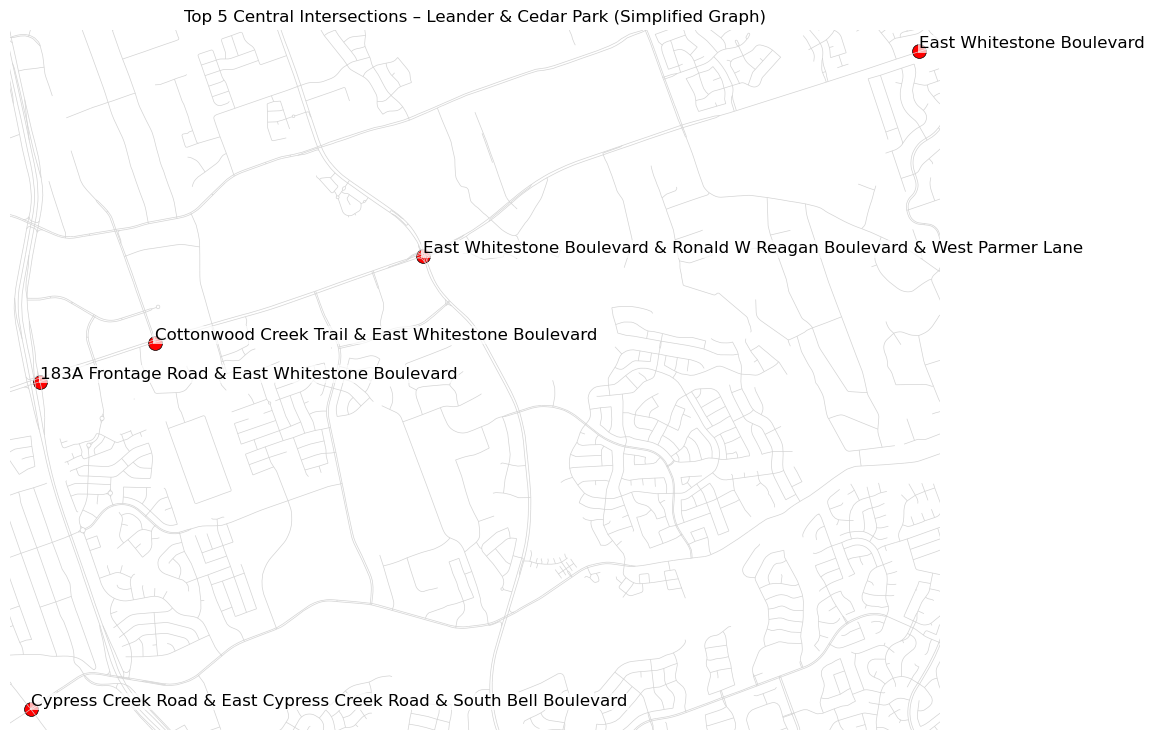

In [14]:
# Plot top 5 central intersections on the road map

gdf_hubs_sorted = gdf_hubs_unique.sort_values("centrality_score", ascending=False)
top7 = gdf_hubs_sorted.head(5).copy()

fig, ax = plt.subplots(figsize=(12, 12))

cp_lea_proj.plot(ax=ax, color="lightgray", linewidth=0.5)

top7.plot(
    ax=ax,
    color="red",
    markersize=100,
    edgecolor="black",
    linewidth=0.5
)

for _, row in top7.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    label = row["intersection_names"]
    ax.text(
        x, y,
        label,
        fontsize=12,
        ha="left",
        va="bottom",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0)
    )

minx, miny, maxx, maxy = top7.total_bounds
pad = 200
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

ax.set_title("Top 5 Central Intersections – Leander & Cedar Park (Simplified Graph)")
ax.set_axis_off()

plt.show()


## Leander & Cedar Park - Question 1 Analysis

#### Helper functions

In [17]:
# Randomly pick pairs of nodes from the graph so we dont have to calculate every combination
def sample_pairs(G, n_pairs=3000, seed=SEED):
    random.seed(seed)
    nodes = sorted(G.nodes())
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes.")
    return [tuple(random.sample(nodes, 2)) for _ in range(n_pairs)]

#Approximate global efficiency only for a sampled set
def approximate_efficiency_from_pairs(G, pairs, weight="travel_time_s"):
    inv_d_sum = 0.0
    count = 0

    for u, v in pairs:
        # Skip pairs involving nodes that are gone (after removals)
        if (u not in G) or (v not in G):
            continue

        try:
            d = nx.shortest_path_length(G, u, v, weight=weight)
            if d > 0:
                inv_d_sum += 1.0 / d
                count += 1
        except nx.NetworkXNoPath:
            # disconnected after removals
            continue

    return inv_d_sum / count if count > 0 else 0.0


#### Edge Closures - Which edges should we protect from closure?
What is the efficiency drop when the top edges are individually removed?

In [19]:
# Edge betweenness and closure impact (simplified graph)
t0 = time.perf_counter()

edge_btw = nx.edge_betweenness_centrality(
    G_cp_lea_simpl,
    k=min(3000, G_cp_lea_simpl.number_of_nodes()),
    weight="travel_time_s",
    seed=SEED
)

# Sample 4000 random origin–destination pairs (instead of all pairs),
pairs_for_edges = sample_pairs(G_cp_lea_simpl, n_pairs=4000, seed=SEED)

# Compute the baseline (before any closures) approximate global efficiency
E_base_edges = approximate_efficiency_from_pairs(
    G_cp_lea_simpl, pairs_for_edges, weight="travel_time_s"
)

# Function: measure how bad it is to close each top edge
def edge_closure_impact_with_roadname(
    G,
    edge_btw,
    E_base,
    roads_3857,
    pairs,
    k=10
):
    # Grab the top-k edges with the highest betweenness scores
    top_items = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:k]
    top_edges = [e for e, _ in top_items]
    top_scores = [b for _, b in top_items]

    # Compute the midpoint of each edge so we can spatially match it to a road name
    midpoints = [
        Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)
        for (u, v) in top_edges
    ]
    
    # Build a GeoDataFrame so we can do a spatial join
    gdf_mid = gpd.GeoDataFrame(
        {"edge": top_edges, "betweenness": top_scores},
        geometry=midpoints,
        crs="EPSG:3857"
    )

    # Spatially match each midpoint to the nearest road segment.
    joined = gpd.sjoin_nearest(
        gdf_mid,
        roads_3857[["name", "geometry"]],
        how="left",
        distance_col="dist",
        max_distance=50
    )
    results = []
    
    #loop through each critical edge and test the effect of closing it
    for idx, row in joined.iterrows():
        (u, v) = row["edge"]
        bscore = row["betweenness"]
        road_name = row.get("name")
        if not isinstance(road_name, str) or not road_name:
            road_name = "Unknown road"

        #make a temporary copy of the graph and remove this one edge
        G_tmp = G.copy()
        if G_tmp.has_edge(u, v):
            G_tmp.remove_edge(u, v)
            # Recompute approximate global efficiency after removing the edge
            E_after = approximate_efficiency_from_pairs(
                G_tmp, pairs, weight="travel_time_s"
            )
            # Percent drop relative to baseline
            drop_pct = (E_base - E_after) / E_base * 100 if E_base > 0 else None
        else:
            E_after = None
            drop_pct = None

        results.append(((u, v), bscore, E_after, drop_pct, road_name))

    df = pd.DataFrame(
        results,
        columns=["edge", "betweenness", "efficiency_after", "eff_drop_pct", "road_name"]
    )

    df_gdf = gpd.GeoDataFrame(
        df,
        geometry=[
            Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)
            for (u, v) in df["edge"]
        ],
        crs="EPSG:3857"
    )

    return df_gdf

# Run the full impact analysis for the CP + Leander region
edge_impact_cp_lea = edge_closure_impact_with_roadname(
    G_cp_lea_simpl,
    edge_btw,
    E_base_edges,
    roads_3857,
    pairs_for_edges,
    k=50
)

edge_table = (
    edge_impact_cp_lea[["road_name", "betweenness", "efficiency_after", "eff_drop_pct"]]
    .sort_values("eff_drop_pct", ascending=False)
    .reset_index(drop=True)
)

t1 = time.perf_counter()
print(f"Centrality section took {t1 - t0:.2f} seconds")

edge_table.head(10)


Centrality section took 356.64 seconds


,road_name,betweenness,efficiency_after,eff_drop_pct
0,Unknown road,0.049071,0.001609,1.263889
1,East Whitestone Boulevard,0.049140,0.001613,0.995838
2,East Whitestone Boulevard,0.049388,0.001613,0.992284
3,East Whitestone Boulevard,0.049128,0.001613,0.979090
4,East Whitestone Boulevard,0.049589,0.001613,0.974302
5,East Whitestone Boulevard,0.054717,0.001616,0.828462
6,East Whitestone Boulevard,0.055241,0.001616,0.816883
7,East Whitestone Boulevard,0.057949,0.001616,0.813850
8,Discovery Boulevard,0.056014,0.001616,0.783489
9,East Whitestone Boulevard,0.058347,0.001617,0.747468


In [20]:
# Corridor-level summary (one row per road name)
road_rank_cp_lea = (
    edge_impact_cp_lea
    .groupby("road_name", as_index=False)
    .agg({"betweenness": "max", "eff_drop_pct": "max"})
    .sort_values("eff_drop_pct", ascending=False)
    .reset_index(drop=True)
)
road_rank_cp_lea.head(10)

,road_name,betweenness,eff_drop_pct
0,Unknown road,0.053483,1.263889
1,East Whitestone Boulevard,0.060153,0.995838
2,Discovery Boulevard,0.056014,0.783489
3,West Parmer Lane,0.055669,0.655522
4,West Whitestone Boulevard,0.050390,0.486150
5,North Vista Ridge Boulevard,0.054005,0.221428


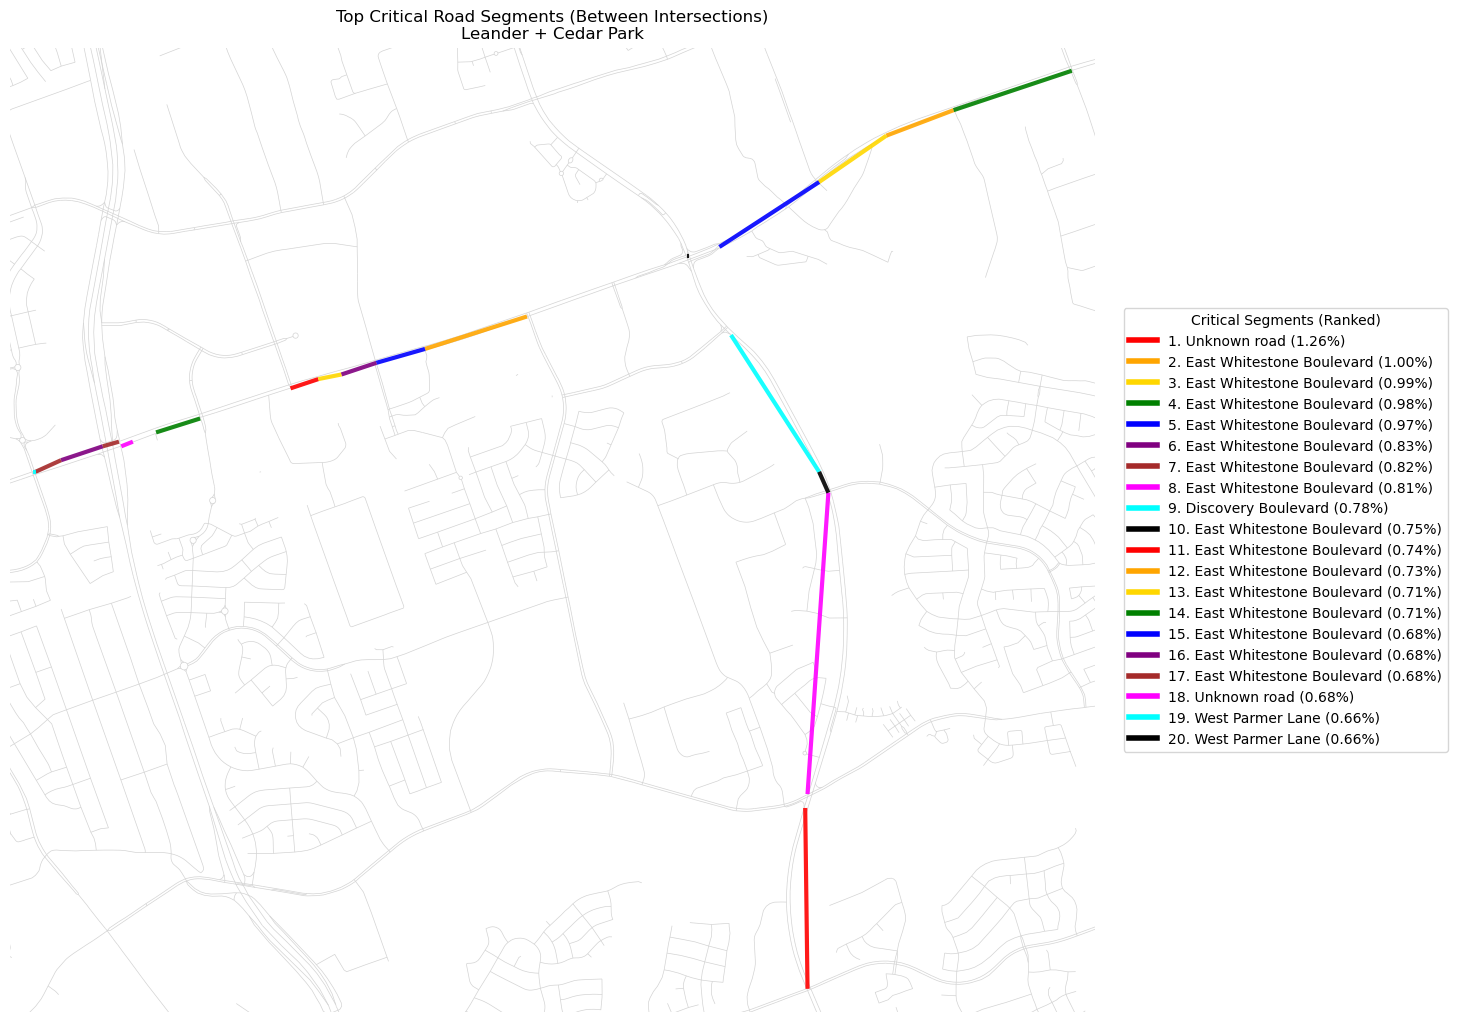

In [21]:
# How many segments to highlight
k_highlight = 20

crit_edges = (
    edge_impact_cp_lea
    .sort_values("eff_drop_pct", ascending=False)
    .head(k_highlight)
    .copy()
)

# Build actual line geometry between intersections
crit_edges["geometry"] = crit_edges["edge"].apply(
    lambda uv: LineString([uv[0], uv[1]])
)

gdf_crit_edges = gpd.GeoDataFrame(
    crit_edges,
    geometry="geometry",
    crs="EPSG:3857"
)

fig, ax = plt.subplots(figsize=(14, 14))

# Base network
cp_lea_proj.plot(ax=ax, color="lightgray", linewidth=0.5)

# Distinct colors
colors = [
    "red", "orange", "gold", "green", "blue",
    "purple", "brown", "magenta", "cyan", "black"
]
gdf_crit_edges["rank"] = range(1, len(gdf_crit_edges) + 1)
gdf_crit_edges["color"] = [
    colors[(r - 1) % len(colors)] for r in gdf_crit_edges["rank"]
]

# Plot segments without labels
for _, row in gdf_crit_edges.iterrows():
    gpd.GeoDataFrame([row], geometry="geometry", crs="EPSG:3857").plot(
        ax=ax,
        color=row["color"],
        linewidth=3,
        alpha=0.9
    )

# build legend
legend_elements = []
for _, row in gdf_crit_edges.iterrows():
    legend_label = f"{row['rank']}. {row['road_name']} ({row['eff_drop_pct']:.2f}%)"
    legend_elements.append(
        Line2D([0], [0], color=row["color"], lw=4, label=legend_label)
    )
ax.legend(
    handles=legend_elements,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    title="Critical Segments (Ranked)"
)

# Zom to the top segments
minx, miny, maxx, maxy = gdf_crit_edges.total_bounds
pad = 150
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

ax.set_title("Top Critical Road Segments (Between Intersections)\nLeander + Cedar Park")
ax.set_axis_off()

plt.show()


## Leander & Cedar Park - Question 2 Analysis

#### Failure Simulation - How robust is the network against removals?
How quickly does the network collapse under failures?
Does the network degrade slowly or catastrophically when edges fail?
How robust is the system when we remove the top edges vs. random edges

Targeted Edges:
“If an intelligent attacker (or disaster) takes out the most important edges first, how fast does mobility collapse?”

Random edges:
“If failures occur randomly (weather events, construction, accidents), how fast does the system degrade on average?”

In [24]:
# Failure simulation: targeted vs random edges
t0 = time.perf_counter()

def simulate_failure_curves(
    G,
    edge_btw,
    max_remove=10,
    n_runs=10,
    n_pairs=400,
    weight="travel_time_s",
    seed=SEED,
):
    random.seed(seed)
    np.random.seed(seed)

    edges = sorted(G.edges())
    m = len(edges)
    max_remove = min(max_remove, m)

    targeted_edges = [e for e, _ in sorted(edge_btw.items(),
                                           key=lambda x: x[1],
                                           reverse=True)]

    nodes = sorted(G.nodes())
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes.")
    pairs = [tuple(random.sample(nodes, 2)) for _ in range(n_pairs)]

    E0 = approximate_efficiency_from_pairs(G, pairs, weight=weight)

    # targeted roads, top k
    G_tar = G.copy()
    E_targeted = [E0]
    for k in range(1, max_remove + 1):
        e = targeted_edges[k - 1]
        if G_tar.has_edge(*e):
            G_tar.remove_edge(*e)
        E_targeted.append(approximate_efficiency_from_pairs(G_tar, pairs, weight=weight))

    # random roads
    E_random_all = np.zeros((n_runs, max_remove + 1))
    for r in range(n_runs):
        G_rand = G.copy()
        order = edges.copy()
        np.random.shuffle(order)
        E_random_all[r, 0] = E0
        for k in range(1, max_remove + 1):
            e = order[k - 1]
            if G_rand.has_edge(*e):
                G_rand.remove_edge(*e)
            E_random_all[r, k] = approximate_efficiency_from_pairs(G_rand, pairs, weight=weight)

    E_random_mean = E_random_all.mean(axis=0)
    E_random_std = E_random_all.std(axis=0)
    ks = np.arange(0, max_remove + 1)

    return pd.DataFrame({
        "k_removed": ks,
        "E_targeted": E_targeted,
        "E_random_mean": E_random_mean,
        "E_random_std": E_random_std
    })

failure_curves = simulate_failure_curves(
    G_cp_lea_simpl,
    edge_btw,
    max_remove=10,
    n_runs=15,
    n_pairs=3000
)
t1 = time.perf_counter()
print(f"Centrality section took {t1 - t0:.2f} seconds")

failure_curves.head()


Centrality section took 781.38 seconds


,k_removed,E_targeted,E_random_mean,E_random_std
0,0,0.001635,0.001635,6.505213e-19
1,1,0.001633,0.001635,1.709348e-06
2,2,0.001621,0.001634,2.376721e-06
3,3,0.001615,0.001634,2.960228e-06
4,4,0.001609,0.001633,3.371835e-06


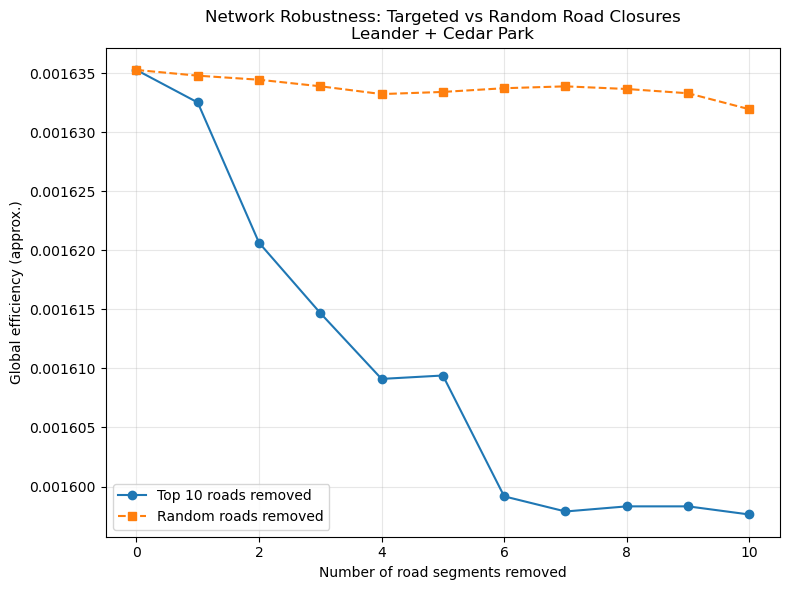

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ks = failure_curves["k_removed"]

# Targeted removal curve
ax.plot(
    ks,
    failure_curves["E_targeted"],
    marker="o",
    linestyle="-",
    label="Top 10 roads removed",
)

# Random removal mean curve
ax.plot(
    ks,
    failure_curves["E_random_mean"],
    marker="s",
    linestyle="--",
    label="Random roads removed",
)


ax.set_xlabel("Number of road segments removed")
ax.set_ylabel("Global efficiency (approx.)")
ax.set_title("Network Robustness: Targeted vs Random Road Closures\nLeander + Cedar Park")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Leander & Cedar Park - Question 3 Analysis

### Top 20 critical roads shut down

#### Helper function

In [29]:
#helper function to calculate eifficeny for repair order

def greedy_repair_order(
    G_base,
    closed_edges,
    pairs,
    weight="travel_time_s"
):
    # start from a damaged copy of the graph
    G_damaged = G_base.copy()
    for (u, v) in closed_edges:
        if G_damaged.has_edge(u, v):
            G_damaged.remove_edge(u, v)

    # Baseline efficiency of the damaged network
    E_damaged = approximate_efficiency_from_pairs(G_damaged, pairs, weight=weight)

    remaining = list(closed_edges)
    repair_results = []

    current_graph = G_damaged
    current_eff = E_damaged

    step = 1
    while remaining:
        best_edge = None
        best_eff = -1.0

        # try to reopen each remaining closed edge one at a time
        for (u, v) in remaining:
            if current_graph.has_edge(u, v): 
                continue

            G_tmp = current_graph.copy()

            if G_base.has_edge(u, v):
                data = G_base[u][v] 
                G_tmp.add_edge(u, v, **data)
            else:
                continue

            # Efficiency after hypothetically restoring this edge
            E_after = approximate_efficiency_from_pairs(G_tmp, pairs, weight=weight)

            # Keep track of the best edge so far
            if E_after > best_eff:
                best_eff = E_after
                best_edge = (u, v)

        #permanently restore the best edge 
        (bu, bv) = best_edge
        if G_base.has_edge(bu, bv):
            current_graph.add_edge(bu, bv, **G_base[bu][bv])

        current_eff = best_eff

        road_name = G_base[bu][bv].get("name", "Unknown road")

        # percent gain relative to the original damaged state
        gain_pct = (current_eff - E_damaged) / E_damaged * 100 if E_damaged > 0 else 0.0

        repair_results.append({
            "step": step,
            "edge": best_edge,
            "road_name": road_name,
            "efficiency_after": current_eff,
            "gain_pct_vs_damaged": gain_pct
        })

        #remove this edge from the list of closed ones and move on
        remaining.remove(best_edge)
        step += 1
        
    return pd.DataFrame(repair_results)


#### Closed roads Calculation & Plot

In [ ]:
t0 = time.perf_counter()

# Choose top-K critical segments (by efficiency drop)
K = 20  # how many critical segments to use

topK_critical = (
    edge_impact_cp_lea
    .sort_values("eff_drop_pct", ascending=False)
    .head(K)
    .copy()
)

# edges that will be closed to create the damaged network
closed_edges_topK = list(topK_critical["edge"])

print(f"Using {len(closed_edges_topK)} edges as initial failures.")

# Run greedy repair order on these same K failures
# Sample node pairs for efficiency during recovery
pairs_for_recovery = sample_pairs(G_cp_lea_simpl, n_pairs=3000, seed=SEED)

repair_table_topK = greedy_repair_order(
    G_base=G_cp_lea_simpl,
    closed_edges=closed_edges_topK,
    pairs=pairs_for_recovery,
    weight="travel_time_s"
)

t1 = time.perf_counter()
print(f"Centrality section took {t1 - t0:.2f} seconds")

repair_table_topK.head()



Using 20 edges as initial failures.


In [ ]:
# merge repair info with the geometry from topK_critical
topK_geom = topK_critical[["edge", "road_name"]].drop_duplicates()
repair_with_geom = repair_table_topK.merge(
    topK_geom,
    on=["edge", "road_name"],
    how="left"
)
repair_with_geom["geometry"] = repair_with_geom["edge"].apply(
    lambda uv: LineString([uv[0], uv[1]])
)
gdf_repair = gpd.GeoDataFrame(
    repair_with_geom,
    geometry="geometry",
    crs="EPSG:3857"
)


#Assign color repiar order to each road segment
steps = gdf_repair["step"].values
norm = mcolors.Normalize(vmin=steps.min(), vmax=steps.max())
cmap = cm.get_cmap("viridis_r")  # dark for early steps, light for later
gdf_repair["color"] = [cmap(norm(s)) for s in steps]

fig, ax = plt.subplots(figsize=(12, 8))

# Base road network
cp_lea_proj.plot(ax=ax, color="lightgray", linewidth=0.4, alpha=0.8)

#plot each segment with its color
for _, row in gdf_repair.iterrows():
    gpd.GeoDataFrame([row], geometry="geometry", crs="EPSG:3857").plot(
        ax=ax,
        color=row["color"],
        linewidth=4,
        alpha=0.95,
        zorder=2
    )

# plot numbered circles at centroids
for _, row in gdf_repair.iterrows():
    cx, cy = row.geometry.centroid.x, row.geometry.centroid.y
    step = int(row["step"])
    ax.scatter(cx, cy, s=80, color=row["color"], edgecolor="black", zorder=3)
    # step number
    ax.text(
        cx, cy,
        str(step),
        fontsize=8,
        ha="center",
        va="center",
        color="white",
        weight="bold",
        zorder=4
    )

# Zoom in to see the segments
minx, miny, maxx, maxy = gdf_repair.total_bounds
pad = 200  # meters
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

# legend
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Repair step (1 = first to reopen)")

ax.set_title(
    "Recovery Priority – Road Segments by Restoration Order\n"
    "Leander + Cedar Park (Top 20 Critical Closures)"
)
ax.set_axis_off()

plt.tight_layout()
plt.show()
